In [16]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\onrik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Python


### 预处理

In [17]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [18]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [19]:
df = pd.read_excel("C:/Users/onrik\\report\\0203_LDA\\DW news 가공_0329.xlsx")
df.columns = ['title','date','content']
df.head()

,title,date,content
0,Ireland fines WhatsApp €225 million for EU pri...,2021-09-02,Ireland's Data Protection Commission on Thursd...
1,Survey: Deutsche Welle would like to know more...,2021-07-16,You're a dw.com user? We're interested ingetti...
2,European online activists target 'cookie banne...,2021-05-31,"The Austria-based NOYB ""None of Your Business""..."
3,Germany's delivery drivers' data privacy threa...,2021-05-28,"""It is much nicer to do this job now than when..."
4,Facebook: Ireland opens privacy probe into tec...,2021-04-14,Ireland's data regulator opened an investigati...


In [20]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm") 
# nlp = spacy.load('zh_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])

# print(data_lemmatized[:1])

In [24]:
data_lemmatized

[['fine',
  'facebook',
  'own',
  'messenging',
  'service',
  'whatsapp',
  'record',
  'privacy',
  'watchdog',
  'increase',
  'exist',
  'fine',
  'break',
  'datum',
  'protection',
  'law',
  'european',
  'regulator',
  'complain',
  'home',
  'regional',
  'headquarters',
  'number',
  'major',
  'tech',
  'player',
  'includingapple',
  'result',
  'datum',
  'protection',
  'commission',
  'responsible',
  'policing',
  'adherence',
  'agency',
  'launch',
  'whatsapp',
  'probe',
  'examine',
  'whatsapp',
  'discharge',
  'gdpr',
  'transparency',
  'obligation',
  'tell',
  'user',
  'datum',
  'use',
  'include',
  'detail',
  'information',
  'process',
  'whatsapp',
  'facebook',
  'company',
  'agency',
  'submit',
  'initial',
  'decision',
  'european',
  'regulator',
  'approval',
  'require',
  'receive',
  'objection',
  'ask',
  'reassess',
  'increase',
  'propose',
  'fine',
  'basis',
  'number',
  'factor',
  'follow',
  'reassessment',
  'dpc',
  'impose',


### TF-IDF

In [25]:
### Term-Frequency
from collections import Counter
words = ''
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    words += t
words = words.split()
counts = Counter(words)
counts

Counter({'fine': 35,
         'facebook': 216,
         'own': 11,
         'messenging': 1,
         'service': 55,
         'whatsapp': 38,
         'record': 5,
         'privacy': 124,
         'watchdog': 6,
         'increase': 18,
         'exist': 16,
         'break': 14,
         'datum': 484,
         'protection': 89,
         'law': 128,
         'european': 71,
         'regulator': 20,
         'complain': 8,
         'home': 8,
         'regional': 1,
         'headquarters': 5,
         'number': 33,
         'major': 16,
         'tech': 18,
         'player': 7,
         'includingapple': 1,
         'result': 19,
         'commission': 9,
         'responsible': 5,
         'policing': 1,
         'adherence': 2,
         'agency': 19,
         'launch': 17,
         'probe': 3,
         'examine': 4,
         'discharge': 1,
         'gdpr': 86,
         'transparency': 27,
         'obligation': 6,
         'tell': 28,
         'user': 166,
         'use': 87,
   

In [26]:
vocab = sorted(counts, key=counts.get, reverse=True)
tf_df = []
for voca in vocab:
    tf_df.append({'word': voca, 'term frequency': counts[voca]})
tf_df = pd.DataFrame(tf_df)
tf_df.head(10)

,word,term frequency
0,datum,484
1,say,325
2,company,218
3,facebook,216
4,user,166
5,law,128
6,privacy,124
7,make,97
8,people,94
9,protection,89


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
contents_tfidf = []
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    contents_tfidf.append(t)
vectorizer = TfidfVectorizer(stop_words='english', max_features= 100)
X = vectorizer.fit_transform(contents_tfidf)

# # TF-IDF 행렬의 크기 확인
# print('TF-IDF 행렬의 크기 :',X.shape)
tf_idfdict=  vectorizer.get_feature_names()
data_array = X.toarray()
data_tdidf = pd.DataFrame(data_array, columns=tf_idfdict)
data_tdidf


,access,account,ad,advertising,allow,app,ask,base,big,breach,...,transparency,use,user,want,way,website,whatsapp,work,world,year
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073808,0.000000,0.071956,0.066911,...,0.180794,0.052801,0.048785,0.000000,0.000000,0.000000,0.735241,0.077823,0.000000,0.057319
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.309580,0.286038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.068519,0.000000,0.000000,0.150015,0.000000,0.150015,...,0.000000,0.000000,0.218755,0.000000,0.075008,0.087240,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.119227,0.215957,0.000000,0.000000,0.070180,0.000000,...,0.000000,0.102994,0.047581,0.143971,0.065259,0.000000,0.000000,0.303606,0.136923,0.167711
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.091813,0.000000,0.083233,0.089509,0.332932,...,0.000000,0.065681,0.121372,0.000000,0.000000,0.000000,0.000000,0.000000,0.087318,0.142603
5,0.000000,0.000000,0.000000,0.000000,0.038551,0.046552,0.000000,0.000000,0.090769,0.000000,...,0.000000,0.000000,0.000000,0.046552,0.042202,0.000000,0.000000,0.049085,0.044273,0.144609
6,0.083063,0.240646,0.000000,0.000000,0.116491,0.656450,0.046889,0.127523,0.000000,0.000000,...,0.000000,0.067087,0.309928,0.140668,0.127523,0.049440,0.066727,0.049440,0.000000,0.000000
7,0.084874,0.000000,0.121438,0.000000,0.000000,0.000000,0.000000,0.086869,0.000000,0.000000,...,0.000000,0.137100,0.000000,0.191646,0.000000,0.000000,0.000000,0.000000,0.091133,0.074416
8,0.028452,0.000000,0.000000,0.000000,0.000000,0.032123,0.032123,0.029121,0.031317,0.029121,...,0.000000,0.068940,0.106163,0.000000,0.029121,0.033870,0.000000,0.000000,0.030550,0.024947
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101733,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087149


In [28]:
def getTFIDF(text_series):
    """Performs TF-IDF calculation on a matrix of words grouped into cells."""
    vectorizer = TfidfVectorizer()

    matrix = vectorizer.fit_transform(text_series).todense()

    matrix_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())


    return matrix_df.sum(axis=0).sort_values(ascending=False)

# # Create Corpus for TD-IDF analysis 
text_df = pd.DataFrame()
text_df["text_clean"] = data_lemmatized # Use the data_lemmatized for text analysis
text_to_tfidf = [",".join(text) for text in text_df["text_clean"].values]

# Getting TD-IDF scores for words 
topwords = getTFIDF(text_to_tfidf)
topwords.to_excel("topwords.xlsx")
topwords_50 = topwords[:50]
topwords_50.to_excel("DWnews_topwords_tf_idf_50.xlsx")

In [29]:
topwords

datum          7.081550
say            4.771050
facebook       4.409851
company        3.745799
user           3.459116
                 ...   
prosecution    0.024702
protein        0.024702
else           0.024702
eickelmann     0.024702
simplicity     0.024702
Length: 3577, dtype: float64

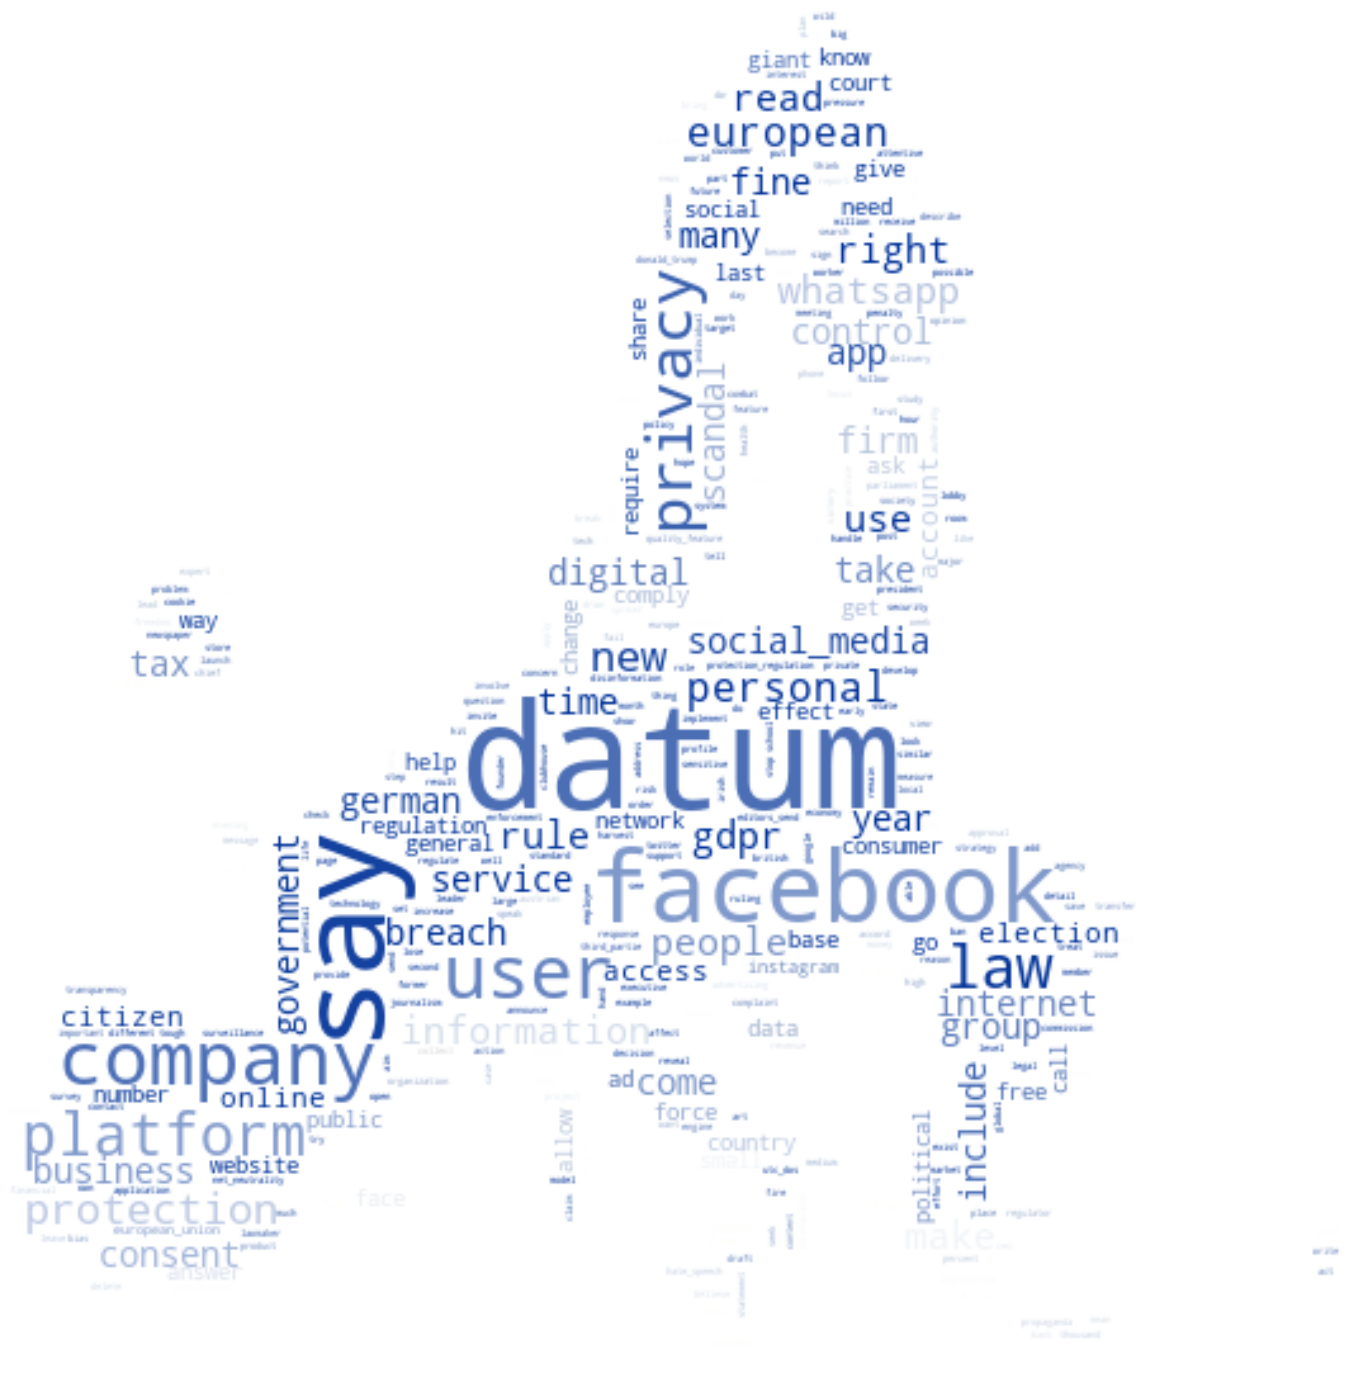

In [30]:
# Importing word cloud
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from PIL import Image

## Creating a masked wordcloud using TD-IDF
fig, ax = plt.subplots(figsize=(25,25))
custom_mask = np.array(Image.open("EU2.jpg"))
w = WordCloud(background_color = 'white',
              width=800,height=600,
              mask = custom_mask,
              mode='RGBA',
              max_words=2000).fit_words(topwords)
image_colors = ImageColorGenerator(custom_mask)
w.recolor(color_func = image_colors)
plt.imshow(w, interpolation="bilinear")
plt.axis("off")
plt.show()
fig.savefig('DWnews_TFIDF_Wordcloud.png', dpi=800)

### LDA

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 5), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 2), (29, 1), (30, 6), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 3), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 3), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 7), (99, 1), (100, 1)]]


In [32]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'mallet-2.0.8/bin/mallet'  # update this path
# mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
import os
os.environ.update({'MALLET_HOME':r'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/'})

mallet_path = 'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path


# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [33]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

[(0,
  [('company', 0.045368620037807186),
   ('service', 0.02551984877126654),
   ('german', 0.023156899810964082),
   ('whatsapp', 0.017958412098298678),
   ('app', 0.01606805293005671),
   ('share', 0.015595463137996219),
   ('country', 0.013705103969754254),
   ('european_union', 0.013232514177693762),
   ('percent', 0.011342155009451797),
   ('require', 0.011342155009451797)]),
 (1,
  [('law', 0.03608736942070275),
   ('breach', 0.017568850902184234),
   ('fine', 0.017094017094017096),
   ('giant', 0.016619183285849954),
   ('information', 0.016619183285849954),
   ('force', 0.01566951566951567),
   ('legal', 0.012345679012345678),
   ('receive', 0.012345679012345678),
   ('european', 0.011870845204178538),
   ('tax', 0.011396011396011397)]),
 (2,
  [('government', 0.02916224814422057),
   ('people', 0.020678685047720042),
   ('internet', 0.019618239660657476),
   ('group', 0.016967126193001062),
   ('public', 0.015906680805938492),
   ('online', 0.015376458112407211),
   ('state'

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=2)

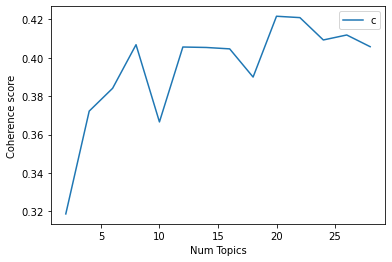

In [36]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
model_list

Num Topics = 2  has Coherence Value of 0.3187
Num Topics = 4  has Coherence Value of 0.3722
Num Topics = 6  has Coherence Value of 0.3841
Num Topics = 8  has Coherence Value of 0.4069
Num Topics = 10  has Coherence Value of 0.3666
Num Topics = 12  has Coherence Value of 0.4057
Num Topics = 14  has Coherence Value of 0.4054
Num Topics = 16  has Coherence Value of 0.4047
Num Topics = 18  has Coherence Value of 0.39
Num Topics = 20  has Coherence Value of 0.4217
Num Topics = 22  has Coherence Value of 0.421
Num Topics = 24  has Coherence Value of 0.4093
Num Topics = 26  has Coherence Value of 0.4119
Num Topics = 28  has Coherence Value of 0.4058


In [40]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.061*"company" + 0.028*"gdpr" + 0.028*"business" + 0.018*"whatsapp" + '
  '0.017*"fine" + 0.016*"european_union" + 0.015*"big" + 0.014*"app" + '
  '0.014*"small" + 0.013*"country" + 0.011*"private" + 0.010*"german" + '
  '0.010*"phone" + 0.010*"follow" + 0.010*"share" + 0.009*"customer" + '
  '0.009*"address" + 0.009*"set" + 0.009*"number" + 0.009*"decision"'),
 (1,
  '0.023*"call" + 0.017*"digital" + 0.015*"technology" + 0.015*"system" + '
  '0.015*"risk" + 0.014*"health" + 0.013*"school" + 0.012*"datum" + '
  '0.012*"people" + 0.011*"measure" + 0.011*"life" + 0.010*"potential" + '
  '0.010*"time" + 0.010*"bias" + 0.010*"important" + 0.009*"lack" + '
  '0.008*"put" + 0.008*"public" + 0.008*"machine" + 0.008*"spread"'),
 (2,
  '0.055*"datum" + 0.044*"facebook" + 0.020*"personal" + 0.016*"user" + '
  '0.016*"firm" + 0.014*"company" + 0.013*"election" + 0.013*"scandal" + '
  '0.012*"political" + 0.011*"claim" + 0.011*"question" + 0.010*"general" + '
  '0.010*"include" + 0.010*"l

In [41]:
ldadf = []
for i in range(len(optimal_model.print_topics(num_words= 20))):
    topic = optimal_model.print_topics(num_words= 20)[i]
    topic_num = 'topic' + ' ' + str(i+1)
    for j in range(len(topic[1].split(" + "))):
        term = topic[1].split(" + ")[j].split("*")[1][1:-1]
        ldanum = topic[1].split(" + ")[j].split("*")[0]
        ldadf.append({"topic": topic_num, 'term':term, 'lda_num':ldanum})
ldadf = pd.DataFrame(ldadf)
print(len(ldadf), ldadf.term.nunique())
ldadf

160 137


,topic,term,lda_num
0,topic 1,company,0.061
1,topic 1,gdpr,0.028
2,topic 1,business,0.028
3,topic 1,whatsapp,0.018
4,topic 1,fine,0.017
...,...,...,...
155,topic 8,issue,0.011
156,topic 8,transfer,0.010
157,topic 8,receive,0.010
158,topic 8,legislation,0.010


In [43]:
# Visualize the topics
# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

AttributeError: 'LdaMallet' object has no attribute 'inference'

In [44]:
ldadf.to_excel("DWnews LDAdf_final2_0329.xlsx", index=False)

In [45]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3690,"company, gdpr, business, whatsapp, fine, europ...",Irelands Data Protection Commission on Thursda...
1,1,6.0,0.1706,"datum, privacy, protection, data, rule, compan...",Youre a dw.com user? Were interested ingetting...
2,2,5.0,0.3335,"internet, service, group, time, make, online, ...","The Austria-based NOYB ""None of Your Business""..."
3,3,6.0,0.4284,"datum, privacy, protection, data, rule, compan...","""It is much nicer to do this job now than when..."
4,4,0.0,0.1793,"company, gdpr, business, whatsapp, fine, europ...",Irelands data regulator opened an investigatio...
5,5,6.0,0.2988,"datum, privacy, protection, data, rule, compan...","In Germany, 90% of individualsdigital data is ..."
6,6,4.0,0.5047,"people, month, year, high, make, app, world, l...",Clubhouse is an exclusive audio communication ...
7,7,7.0,0.2124,"law, government, personal, state, european, fo...",EU Internal Market Commissioner Thierry Breton...
8,8,7.0,0.4027,"law, government, personal, state, european, fo...",Laws in India regarding data privacy were ambi...
9,9,6.0,0.2477,"datum, privacy, protection, data, rule, compan...",German data protection authorities said Thursd...


In [46]:
df_dominant_topic.to_excel("DWnews_토픽별docu.xlsx",index=False)

### NER

In [29]:
import spacy
from spacy import displacy
import en_core_web_sm

nlp = en_core_web_sm.load()
def NER(lst):
    doc = nlp(lst)
    NERlst = []
    for X in doc.ents:
    #     NERlst.append((X.text, X.label_))
        if X.label_ == 'ORG':
            NERlst.append(X.text)

    return NERlst
qq =  df

qq['content'] = data_words_nostops
nlpdf = qq[['content']]
de_doc = []
for i in range(len(data_words_nostops)):
    t = ' '.join(data_words_nostops[i])
    de_doc.append(t)
qq['content'] = de_doc
nlpdf = qq[['content']]    
nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))
nlpdf

<ipython-input-29-939e1312cae3>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))


,content,NER result
0,irelands data protection commission thursday f...,[irelands data protection commission]
1,youre dw com user interested ingetting know be...,[]
2,austria based noyb none business group monday ...,"[max, max, european union, eu us data exchange]"
3,much nicer job snow ground miguel laughs cycle...,"[miguel worked office job government berlin, e..."
4,irelands data regulator opened investigation f...,[eu governments broughtin blocs]
5,germany data analyzed thats according helge br...,"[european commission eu, pym, pym container]"
6,clubhouse exclusive audio communication app ga...,"[android, ebay way solmecke, general data prot..."
7,eu internal market commissioner thierry breton...,"[eu share data, eu digital governance, wto, eu..."
8,laws india regarding data privacy ambiguous lo...,"[european union, theeuropean unions general da..."
9,german data protection authorities said thursd...,"[german data protection, european union, caspar]"


In [30]:
from nltk.probability import FreqDist
NERll = nlpdf['NER result'].sum()
fdist = FreqDist(NERll)
top_20 = fdist.most_common(20)
top_20

[('zuckerberg', 15),
 ('european union', 13),
 ('european commission', 10),
 ('max', 9),
 ('android', 9),
 ('european court', 7),
 ('general data protection', 6),
 ('white house', 6),
 ('eu data protection', 5),
 ('reuters', 3),
 ('eu data', 3),
 ('eu general data protection', 2),
 ('pym', 2),
 ('pym container', 2),
 ('caspar', 2),
 ('wall street journal', 2),
 ('congress', 2),
 ('stanford', 2),
 ('continental', 2),
 ('lufthansa', 2)]